# MyGamePass #
## User Data Clean-Up ##

A dataset of anonymous Steam user purchase/play information was acquired from Kaggle published by Tamber. 

https://www.kaggle.com/tamber/steam-video-games

The dataset contains 200,000 steam user/game interactions.  This will be the foundation of my collaborative filtering modeling, however it will need to be cleaned and preprocessed.

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
# Import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read in the 200,000 steam user/game interaction data and view a the first few rows
user_df = pd.read_csv('data/steam_users.csv', header=None)
user_df.head(3)

,0,1,2,3,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0


- Great!  This will be very useful data.
- Without a provided header we will name these columns and tidy up a bit

Column: Description
- **0**: unique user id
- **1**: video game name corresponding with the steam store listing
- **2**: purchase/play (that is redundant, will focus on the play information)
- **3**: for all purchases this is 1, for the play entries it is hours played 
- **4**: nothing, will drop

In [3]:
# Rename the columns that I will keep
user_df.rename(columns={0:'user_id',
                        1:'app_name',
                       3:'hours_played'},inplace=True)

# Purchase/Play is redundant, filter the dataframe to contain just the hours played
user_df = user_df[user_df[2]=='play']

In [4]:
user_df.head(3)

,user_id,app_name,2,hours_played,4
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
3,151603712,Fallout 4,play,87.0,0
5,151603712,Spore,play,14.9,0


In [5]:
# Drop the column that says play, beacuse if there are hours_played it is implied
user_df.drop(columns=[2,4],inplace=True)

In [6]:
user_df.head(3)

,user_id,app_name,hours_played
1,151603712,The Elder Scrolls V Skyrim,273.0
3,151603712,Fallout 4,87.0
5,151603712,Spore,14.9


#### Now I am going to add the Steam appid to this dataframe ####

In [7]:
# Read in just the appid and app name from the steam master dataframe
steam_df = pd.read_csv('data/steam_store/steam.csv', usecols=['appid','name'])
steam_df.head(3)

,appid,name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat


In [8]:
# Create a new dataframe merging the two on the Video Game Name
df = user_df.merge(steam_df,left_on='app_name',right_on='name')
df.drop('name',axis=1,inplace=True)
df.head(3)

,user_id,app_name,hours_played,appid
0,151603712,Fallout 4,87.0,377160
1,87445402,Fallout 4,83.0,377160
2,25096601,Fallout 4,1.6,377160


## Let's explore this data a little more now that it is cleaned up ##

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36302 entries, 0 to 36301
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       36302 non-null  int64  
 1   app_name      36302 non-null  object 
 2   hours_played  36302 non-null  float64
 3   appid         36302 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 1.4+ MB


- Currently at 36,302 rows, 4 columns

In [10]:
# How many individual users are in this dataset?
num_users = len(df['user_id'].unique())
print(f'Number of users: {num_users}')

# How many unique games?
num_games = len(df['appid'].unique())
print(f'Number of games: {num_games}')

Number of users: 9248
Number of games: 1724


In [11]:
# What is the average number of games played per user?
avg_games_played = int(round(df.groupby('user_id').agg({'appid':'count'}).mean()))
print(f'Average number of games per user: {avg_games_played}')

# What is the most games a user has played?
max_games_played = int(df.groupby('user_id').agg({'appid':'count'}).max())
print(f'Most games played by a user: {max_games_played}')

Average number of games per user: 4
Most games played by a user: 260


In [12]:
# Let's add a column that shows how many games each user has played
df['user_num_games'] = df.groupby('user_id')['appid'].transform('count')
df.head(3)

,user_id,app_name,hours_played,appid,user_num_games
0,151603712,Fallout 4,87.0,377160,16
1,87445402,Fallout 4,83.0,377160,2
2,25096601,Fallout 4,1.6,377160,25


- Okay this is starting to look a lot better
- This will be used to guide recommendations, so gamers who have only played 1 or 2 games do not add value to the model, they will be dropped

In [13]:
# Filter dataframe for only users who have played more than 3 games
df = df[df['user_num_games'] > 3]

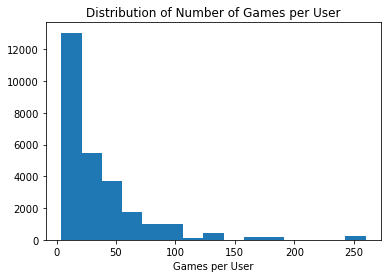

In [14]:
# Distribution of Games per User
plt.figure()
plt.hist(df['user_num_games'],bins=15)
plt.title('Distribution of Number of Games per User')
plt.xlabel('Games per User')
plt.show()

- Another key note, if certain games are overwhelmingly popular they can bias the recommender system. Let's take a look at the most popular games

In [15]:
# Top 10 most popular games played in this dataset
df.groupby(['app_name','appid']).agg({'user_id':'count'}).sort_values(by='user_id',ascending=False).head(10)

,,user_id
app_name,appid,
Team Fortress 2,440,1057
Dota 2,570,824
Unturned,304930,643
Left 4 Dead 2,550,621
Garry's Mod,4000,569
Portal 2,620,413
Terraria,105600,398
Borderlands 2,49520,359
PAYDAY 2,218620,352


- Perhaps unsurprisingly, the games that Steam has developed themselves dominate the top 10 list here.  This could cause our system to over-recommend these games
- Additionally, the recommender system is designed to help discover new or less known games that you would like to play, not simply the most popular game

In [16]:
# What is the average number of users per game?
avg_popularity = int(round(df.groupby('appid').agg({'user_id':'count'}).mean()))
print(f'Average number of users per game: {avg_popularity}')

# What is the most games a user has played?
max_popularity = int(df.groupby('appid').agg({'user_id':'count'}).max())
print(f'Most popular game max users: {max_popularity}')

Average number of users per game: 16
Most popular game max users: 1057


In [17]:
# Let's add a column that shows how many games each user has played
df['game_popularity'] = df.groupby('appid')['user_id'].transform('count')
df.head(3)

,user_id,app_name,hours_played,appid,user_num_games,game_popularity
0,151603712,Fallout 4,87.0,377160,16,144
2,25096601,Fallout 4,1.6,377160,25,144
5,4834220,Fallout 4,19.8,377160,5,144


- Following the similar logic as before, if a game has only been played by a couple people in the dataset it will not be valuable for my model and will be filtered out

In [18]:
# Filter dataframe for only users who have played more than 3 games
df = df[df['game_popularity'] > 3]

In [19]:
df.shape

(25643, 6)

- Looks like we have whittled it down to 25,643 rows and added those 2 columns.  Great!

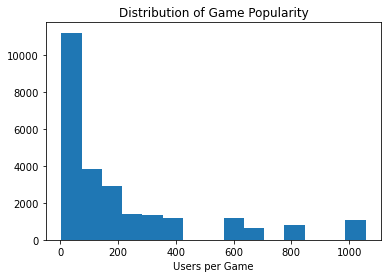

In [20]:
# Let's take a look at the distribution of popularity
plt.figure()
plt.hist(df['game_popularity'],bins=15)
plt.title('Distribution of Game Popularity')
plt.xlabel('Users per Game')
plt.show()

- We can see a clear gap between most popular games and the rest.  It may improve the model to set these aside

In [21]:
# # This can be tested later..
# # Filter dataframe for only users who have played more than 3 games
# df = df[df['game_popularity'] < 500]

- Moving on to the hours_played column, this is crucial for the model.
- As I will be using the Surprise package for my FunkSVD, I will need to conver the hours_played into a rating (I will decide between 1-5 or 1-10)

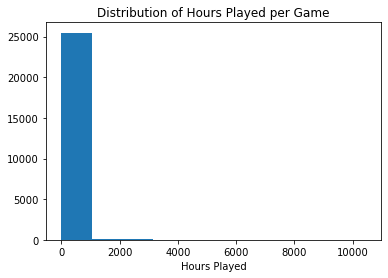

In [22]:
# Take a look at distribution of hours_played
plt.figure()
plt.hist(df['hours_played'])
plt.title("Distribution of Hours Played per Game")
plt.xlabel("Hours Played")
plt.show()

- Okay looks like we have some major outliers to take care of here... let's take a look

<AxesSubplot:xlabel='hours_played'>

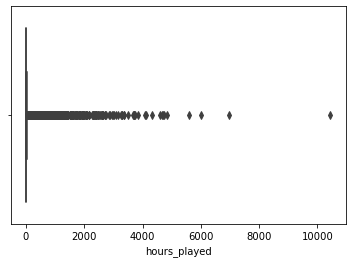

In [23]:
sns.boxplot(x=df['hours_played'])

In [24]:
df['hours_played'].describe()

count    25643.000000
mean        41.086211
std        214.591177
min          0.100000
25%          1.100000
50%          4.400000
75%         17.200000
max      10442.000000
Name: hours_played, dtype: float64

- Looking at this data, it appears we need to set an upper bound.  No human on earth has played a video game for 10,442 hours...that is ridiculous.
- Using a combination of the mean + standard deviation and my own domain knowlege, I will choose to set the limit at 300 hours
    - One point to note, this is a reasonable amount for an online multiplayer game
    - For a single player game, 40-100 hours would be considered a lot of time


- To improve this analysis we could compare the users hours_played for that game compared to the average_hours_played for that user across all of their games.
- Additionally, you could compare the users hours_played compared to the global hours_played 

In [25]:
outliers = df[df['hours_played'] > 300]

In [26]:
num_outliers = len(outliers)
print(num_outliers)

628


In [27]:
num_users = len(df['hours_played'])

In [28]:
num_outliers / num_users * 100

2.4490114261201885

- Going to drop the extreme outliers above 300 hours played which represent 2.5% of the data

In [29]:
df = df[df['hours_played'] <= 300]

<AxesSubplot:xlabel='hours_played'>

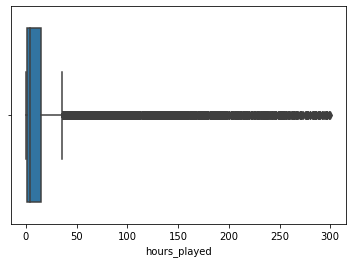

In [30]:
# Let's take another look now
sns.boxplot(x=df['hours_played'])

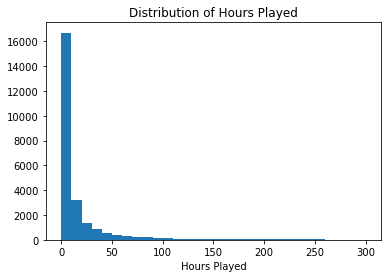

In [31]:
# And the distribution of hours played
plt.figure()
plt.hist(df['hours_played'],bins=30)
plt.title('Distribution of Hours Played')
plt.xlabel('Hours Played')
plt.show()

In [32]:
# Pandas qcut is a perfect function for this.  
# It will automatically cut the dataset into equal sized bins q=num bins
bins = pd.qcut(df['hours_played'], q=5)
bins.value_counts()

(0.099, 0.8]     5285
(7.1, 21.0]      5028
(2.5, 7.1]       4952
(21.0, 300.0]    4921
(0.8, 2.5]       4829
Name: hours_played, dtype: int64

In [33]:
# Awesome that will work great.  Let's add it to the dataframe!
bin_labels_5 = [1,2,3,4,5]
df['rating_5'] = pd.qcut(df['hours_played'],q=5,labels=bin_labels_5)
df.head(3)

,user_id,app_name,hours_played,appid,user_num_games,game_popularity,rating_5
0,151603712,Fallout 4,87.0,377160,16,144,5
2,25096601,Fallout 4,1.6,377160,25,144,2
5,4834220,Fallout 4,19.8,377160,5,144,4


In [34]:
# Let's do 1-10 as well and see how it affects the model
bin_labels_10 = [1,2,3,4,5,6,7,8,9,10]
df['rating_10'] = pd.qcut(df['hours_played'],q=10,labels=bin_labels_10)
df.head(3)

,user_id,app_name,hours_played,appid,user_num_games,game_popularity,rating_5,rating_10
0,151603712,Fallout 4,87.0,377160,16,144,5,10
2,25096601,Fallout 4,1.6,377160,25,144,2,4
5,4834220,Fallout 4,19.8,377160,5,144,4,8


- Voila!

In [35]:
# Export cleaned up csv and confirm
df.to_csv('data/user_clean.csv',index=False)
newdf = pd.read_csv('data/user_clean.csv')
newdf.head()

,user_id,app_name,hours_played,appid,user_num_games,game_popularity,rating_5,rating_10
0,151603712,Fallout 4,87.0,377160,16,144,5,10
1,25096601,Fallout 4,1.6,377160,25,144,2,4
2,4834220,Fallout 4,19.8,377160,5,144,4,8
3,65229865,Fallout 4,0.5,377160,16,144,1,2
4,65958466,Fallout 4,123.0,377160,46,144,5,10


### Awesome!  We are ready for collaborative filtering! ###